In [3]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import dlib
import matplotlib.patches as mpatches
from skimage import io, transform
import numpy as np
import cv2
!pip install easyocr
import easyocr
import csv
import spacy

     |████████████████████████████████| 63.6 MB 57 kB/s 
     |████████████████████████████████| 47.6 MB 1.6 MB/s 


In [37]:
# Using DLIB for face detection
detector = dlib.get_frontal_face_detector()
image = io.imread("/content/IDjpg.jpg")
dets = detector(image, 2)

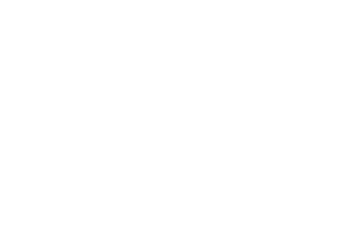

In [38]:
## Visualize the recognized image
plt.figure()
ax = plt.subplot(111)

plt.axis("off")
for i, face in enumerate(dets):
    # Annotate faces in pictures and display
    left = face.left()
    top = face.top()
    right = face.right()
    bottom = face.bottom()
    rect = mpatches.Rectangle((left,bottom), right - left, top - bottom,
                              fill=False, edgecolor='green', linewidth=1)
    ax.add_patch(rect)
plt.show()

predictor = dlib.shape_predictor("/content/shape_predictor_5_face_landmarks.dat")
detected_landmarks = predictor(image, dets[0]).parts()
landmarks = np.array([[p.x, p.y] for p in detected_landmarks])

In [39]:
## Calculate the tilt angle of the eyes,Counterclockwise angle
def twopointcor(point1,point2):
    """point1 = (x1,y1),point2 = (x2,y2)"""
    deltxy = point2 - point1
    corner = np.arctan(deltxy[1] / deltxy[0]) * 180 / np.pi
    return corner

In [40]:
## Calculate average from multiple angles
corner10 =  twopointcor(landmarks[1,:],landmarks[0,:])
corner23 =  twopointcor(landmarks[3,:],landmarks[2,:])
corner20 =  twopointcor(landmarks[2,:],landmarks[0,:])
corner = np.mean([corner10,corner23,corner20])

In [41]:
## Calculate the tilt angle of the image ID card
def IDcorner(landmarks):
    """landmarks:Detected faces5Feature points
              After testing using the first0And2The calculation angle of two feature points is more appropriate
    """
    corner20 =  twopointcor(landmarks[2,:],landmarks[0,:])
    corner = np.mean([corner20])
    return corner
corner = IDcorner(landmarks)

In [42]:
## Tilt the photo
def rotateIdcard(image):
    "image :Image to be processed"
    ## used dlib.get_frontal_face_detector for Face recognition
    detector = dlib.get_frontal_face_detector()
    dets = detector(image, 2)
    ## Detect where the eyes of the face are
    predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")
    detected_landmarks = predictor(image, dets[0]).parts()
    landmarks = np.array([[p.x, p.y] for p in detected_landmarks])
    corner = IDcorner(landmarks)
    ## Rotated image
    image2 = transform.rotate(image,corner,clip=False)
    image2 = np.uint8(image2*255)
    ## Face position after rotation
    det = detector(image2, 2)
    return image2,det


image2,dets = rotateIdcard(image)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB) # Converting image to RGB format

In [43]:
# Saving the image
cv2.imwrite('2 rotated_img.jpg',image2)

True

In [44]:
# Taking the previously saved image as input to extract face photo
input_image_path = '2 rotated_img.jpg'
img = cv2.imread(input_image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
invGamma = 1.0 / 0.3
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

In [45]:
# apply gamma correction using the lookup table
gray = cv2.LUT(gray, table)
ret, thresh1 = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

In [46]:
def biggestRectangle(contours):
    biggest = None
    max_area = 0
    indexReturn = -1
    for index in range(len(contours)):
        i = contours[index]
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.1 * peri, True)
            if area > max_area:  # and len(approx)==4:
                biggest = approx
                max_area = area
                indexReturn = index
    return indexReturn


indexReturn = biggestRectangle(contours)
hull = cv2.convexHull(contours[indexReturn])

In [47]:
# create a crop mask
mask = np.zeros_like(img)  # Create mask where white is what we want, black otherwise
cv2.drawContours(mask, contours, indexReturn, 255, -1)  # Draw filled contour in mask
out = np.zeros_like(img)  # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

In [48]:
# crop the image
(y, x, _) = np.where(mask == 255)
(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = img[topy : bottomy + 1, topx : bottomx + 1, :]
cv2.imwrite('3 cropped_img.jpg',out)

True

In [49]:
reader = easyocr.Reader(['en'])
image = cv2.imread("/content/3 cropped_img.jpg")
output = reader.readtext(image)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [50]:
# We point OpenCV's CascadeClassifier function to where our 
# classifier (XML file format) is stored
face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [51]:
# Our classifier returns the ROI of the detected face as a tuple
# It stores the top left coordinate and the bottom right coordiantes
faces = face_classifier.detectMultiScale(gray, 1.3, 5)

In [52]:
# When no faces detected, face_classifier returns and empty tuple
if faces is ():
    print("No faces found")

In [53]:
# We iterate through our faces array and draw a rectangle
# over each face in faces
for (x, y, w, h) in faces:
    x = x - 25 # Padding trick to take the whole face not just Haarcascades points
    y = y - 40 # Same here...
    cv2.rectangle(image, (x, y), (x + w + 50, y + h + 70), (27, 200, 10), 2)
    cv2.destroyAllWindows()

for (x, y, width, height) in faces:
    roi = image[y:y+height, x:x+width]
    cv2.imwrite("4 Face_crop.jpg", roi) # Saving the extracted face photo

In [63]:
# Extracting and printing out the details from the ID card
print("Unique ID:",output[3][1])
print("=====================")
print("Name:",output[4][1])
print("=====================")

IndexError: ignored

In [55]:
# Saving the extracted details to a CSV file
with open('Database.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Serial No.", "Name", "Unique ID"])

In [56]:
with open('Database.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([1, output[4][1], output[3][1]])

In [57]:
# Using SpaCy for named entity recognition    
nlp = spacy.load("en_core_web_sm")

In [58]:
output = ''.join(map(str, output))
sent = nlp('Aniruddha Mulay')
print([token for token in sent if token.ent_type_ == 'PERSON'])

[]
